
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `TF-IDF` + `LinearSVC` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import re
import string

In [8]:
df = pd.read_csv('../Datas/data.csv')
df.head()
df.sample(n=5)

,category,content
454,Ekonomi,Karadenizli balıkçılar sezonu buruk kapatıyor ...
753,Kültürel,Uluslararası Çubuk Turşu ve Kültür Festivali; ...
514,Ekonomi,"n içme sütü üretimi arttı, peynir üretimi azal..."
821,Savaşlar,"1996 Sivas saldırısı, 29 Ekim 1996'da Türkiye'..."
621,Kültürel,İstanbul Tiyatro Festivali İstanbul'da yapılan...


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)


In [9]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

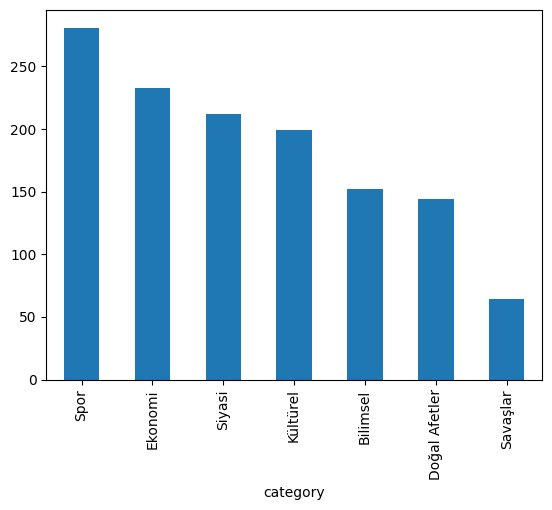

In [10]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [11]:
X = df['processed_data']
y = df['category']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded # verinin %20’si test, %80’i eğitim için kullanılacak.
)

In [12]:
from sklearn.pipeline import Pipeline

# TF-IDF ile metin sayısallaştırılır
# LinearCSVC modeli seçiliyor
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9
    )),
    ('clf', LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=10000
    ))
])


In [13]:
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=3,
                                 ngram_range=(1, 2))),
                ('clf', LinearSVC(class_weight='balanced', max_iter=10000))])

In [14]:
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.89
               precision    recall  f1-score   support

     Bilimsel       0.81      0.83      0.82        30
Doğal Afetler       0.97      0.97      0.97        29
      Ekonomi       0.83      0.94      0.88        47
     Kültürel       0.85      0.72      0.78        40
     Savaşlar       1.00      0.85      0.92        13
       Siyasi       0.93      0.95      0.94        42
         Spor       0.95      0.95      0.95        56

     accuracy                           0.89       257
    macro avg       0.90      0.89      0.89       257
 weighted avg       0.90      0.89      0.89       257



## Değerlendirme
- Accuracy = 0.89
- Precision, Recall, F1-score değerleri yukarıda verilmiştir.


In [15]:
# Kendi istediğimiz metinlerle denemek için
def predict_category(text):
    processed = preprocess_text(text)
    prediction = model.predict([processed])
    return label_encoder.inverse_transform(prediction)[0]

# Test etmek için örnek cümle
predict_category("2023 depremi ülke çapında çok büyük ses getirdi")


'Doğal Afetler'

In [16]:
import numpy as np # Rastgele sayı üretimi için numpy gerekli

# --- CSV'den Rastgele Bir Satır Seçip Test Etme ---
print("\n--- CSV'den Rastgele Örnek Tahmini ---")

row_count = len(df) + 1

# Dataframe'den rastgele bir satır seç
# random_state'i np.random.randint ile her çalışmada farklı bir örnek seçmesini sağlıyoruz
random_row = df.sample(n=1, random_state=np.random.randint(0, row_count)).iloc[0]

# Orijinal metin ve gerçek kategori
original_content = random_row['content']
true_category = random_row['category']

# Modeli kullanarak tahmin yap
# Dikkat: preprocess_text fonksiyonunun global olarak erişilebilir olduğundan emin olun
predicted_category = predict_category(original_content)

# İsterseniz birden fazla rastgele örnek için bu kısmı bir döngüye alabilirsiniz:
print("\n--- 5 Rastgele Örnek Tahmini ---")
for _ in range(5):
    random_row = df.sample(n=1, random_state=np.random.randint(0, row_count)).iloc[0]
    original_content = random_row['content']
    true_category = random_row['category']
    predicted_category = predict_category(original_content)
    print(f"Metin: '{original_content[:70]}...'")
    print(f"Gerçek: {true_category}, Tahmin: {predicted_category}")
    if true_category == predicted_category:
        print("  ✅ Doğru")
    else:
        print("  ❌ Yanlış")
    print("-" * 20)


--- CSV'den Rastgele Örnek Tahmini ---

--- 5 Rastgele Örnek Tahmini ---
Metin: 'Uluslararası Portakal Çiçeği Karnavalı 2013 yılından beri Adana’da Nis...'
Gerçek: Kültürel, Tahmin: Kültürel
  ✅ Doğru
--------------------
Metin: 'run sektöre değer katmaya devam ediyo Turon9 sektöre attığı adımlar il...'
Gerçek: Ekonomi, Tahmin: Ekonomi
  ✅ Doğru
--------------------
Metin: 'Bağımsız ve güvenilir kaynaklar kullanarak maddeyi geliştirebilir ve k...'
Gerçek: Bilimsel, Tahmin: Bilimsel
  ✅ Doğru
--------------------
Metin: '1950 Türkiye cumhurbaşkanlığı seçimi, 22 Mayıs 1950 tarihinde Türkiye ...'
Gerçek: Siyasi, Tahmin: Siyasi
  ✅ Doğru
--------------------
Metin: 'PT-VX400NT Panasonic den Yeni Nesil Kablosuz Projeksiyon Projektör paz...'
Gerçek: Bilimsel, Tahmin: Bilimsel
  ✅ Doğru
--------------------


In [19]:
# Modeli kaydetme
import joblib

joblib.dump(model, '../Models/Supervised/text_classifier_model.pkl')
joblib.dump(label_encoder, '../Models/Supervised/label_encoder.pkl')


['../Models/Supervised/label_encoder.pkl']

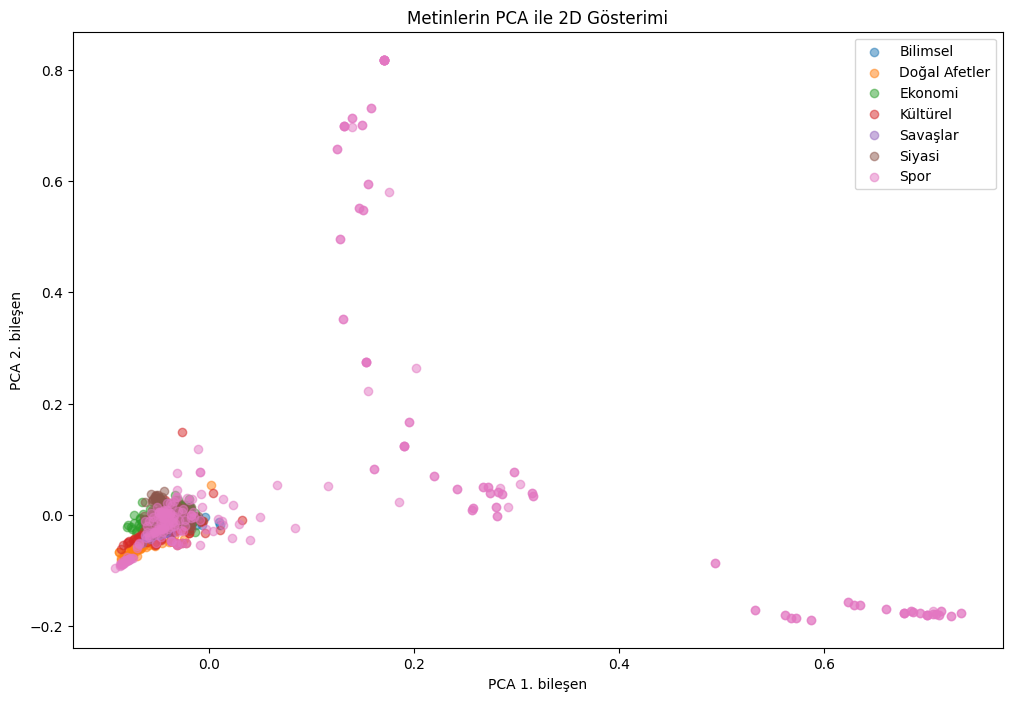

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. TfidfVectorizer ile metinleri vektör haline getir
X_tfidf = model.named_steps['tfidf'].transform(X)  # tüm veri için

# 2. PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 3. Her veri noktası kategorisine göre renklendirme
import numpy as np

plt.figure(figsize=(12,8))

for category in np.unique(y_encoded):
    idx = np.where(y_encoded == category)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label_encoder.inverse_transform([category])[0], alpha=0.5)

plt.legend()
plt.title('Metinlerin PCA ile 2D Gösterimi')
plt.xlabel('PCA 1. bileşen')
plt.ylabel('PCA 2. bileşen')
plt.show()


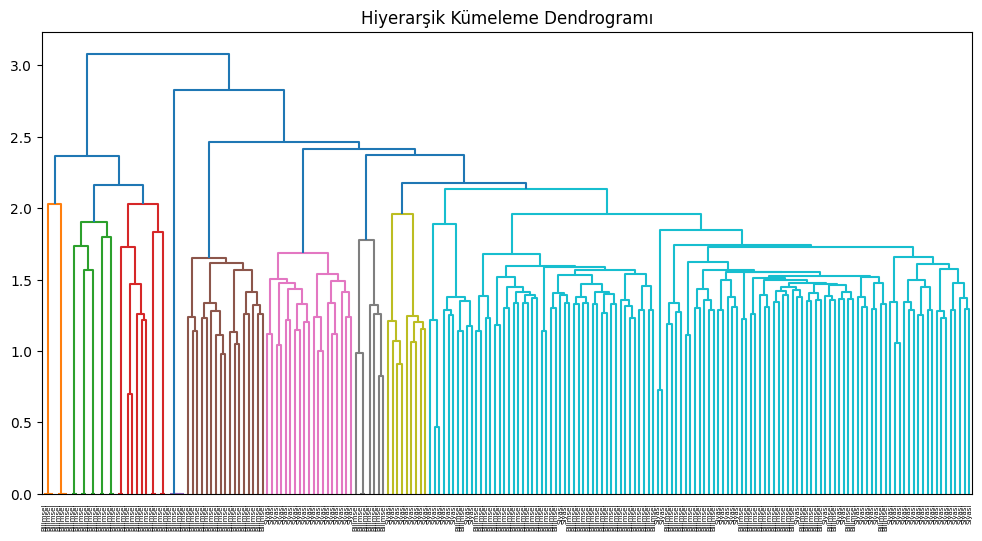

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

# linkage matrisi oluştur (örneğin 'ward' yöntemi)
Z = linkage(X_tfidf.toarray()[:200], method='ward')  # hız için 200 örnekle sınırlı

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=y[:200].values, leaf_rotation=90)
plt.title('Hiyerarşik Kümeleme Dendrogramı')
plt.show()
